In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!git clone https://github.com/Mahsarnzh/XAI_Nuc.git 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'XAI_Nuc'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 145 (delta 26), reused 25 (delta 9), pack-reused 79
Receiving objects: 100% (145/145), 4.23 MiB | 10.07 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 7.4 MB/s eta 0:00:00


In [3]:
import sys
import os
sys.path.append("/content/XAI_Nuc/")

In [4]:
import shap

In [5]:
%cd /content/XAI_Nuc

/content/XAI_Nuc


In [6]:
import criticNet.model
import actorNet.model

In [7]:
import criticNet_env.model
import actorNet_env.model

In [8]:
model_actorNet = actorNet.load_model(os.path.join(os.path.dirname(actorNet.__file__), "weights.h5"))
model_criticNet = criticNet.load_model(os.path.join(os.path.dirname(criticNet.__file__), "weights.h5"))

In [9]:
model_actorNet_env = actorNet_env.load_model(os.path.join(os.path.dirname(actorNet_env.__file__), "weights.h5"))
model_criticNet_env = criticNet_env.load_model(os.path.join(os.path.dirname(criticNet_env.__file__), "weights.h5"))

In [10]:
! pip install onnx_tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 24.3 MB/s eta 0:00:00


In [11]:
import onnx
from onnx_tf.backend import prepare



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 



In [12]:
import onnx

from onnx_tf.backend import prepare

actorNet_onnx_model = onnx.load("actorNet.onnx")  # load onnx model
tf_rep = prepare(actorNet_onnx_model)  # prepare tf representation
tf_rep.export_graph("output_path")  

In [13]:
import tensorflow as tf
import numpy as np

# Load the ONNX model
actorNet_onnx = onnx.load("actorNet.onnx")

# Prepare the ONNX model for TensorFlow
actorNet_onnx_model = prepare(actorNet_onnx)

In [372]:
import numpy as np
import gym
from gym import spaces
import itertools
from gym.spaces import Box

class Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A(gym.Env):
    def __init__(self):
        self.NumComponents = 1
        self.MaxTime = 200
        self.RefuelPeriod = 18
        self.MaxInitialHealth = 0.9999
        self.MinInitialHealth = 0.8
        self.InitialHealthNoise = 0.01
        self.MinHealth = 0
        self.DegradationMean = 0.05
        self.DegradationVar = 0.1
        self.SensorNoiseVar = 0
        self.LeadTime = 5
        self.PenaltyForThirdCapacity = -40
        self.PenaltyForHalfCapacity = -60
        self.PenaltyForNotOperating = -100
        self.CostToRepair = -10
        self.CostToReplace = -5
        self.CostToOrder = -15
        self.CostInventory = -1
        
        self.ObservationInfo = spaces.Box(low=-np.inf, high=np.inf, shape=(5, 1), dtype=np.float32)

        elements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])

        ActionInfo = elements.tolist()
        self.ActionInfo = ActionInfo

        # self.State = np.zeros((5, 1))
        self.IsDone = 0
        
    def step(self, action):
        MaintDecision1 = action[0]
        OrderPart1 = action[1]
        # print(OrderPart1, MaintDecision1)

        Month = self.State[0]
        Component1 = self.State[1]
        Inv1 = self.State[2]
        ArrivalDate1 = self.State[3]
        PartReplaced1 = self.State[4]
        
        Month += 1
        PartReplaced1 = 0
        # print(Inv1, MaintDecision1)

        if MaintDecision1 == 2 and Inv1 > 0:  # Replace
            Inv1 -= 1
            Component1 = self.MaxInitialHealth - np.random.gamma(self.InitialHealthNoise)
            PartReplaced1 = 1
            

            if Component1 < self.MinInitialHealth:
                Component1 = self.MinInitialHealth
                print(Component1)

        elif MaintDecision1 == 1:  # Repair
            Component1 += (self.MaxInitialHealth - Component1) * 0.1  # about 10 percent increase in health gap
            print(Component1)



        if Month % self.RefuelPeriod != 0:
            Component1 -= np.abs(self.DegradationMean + self.DegradationVar * np.random.randn()) * (1 - Component1)
        
        # Component1 = max(Component1, 0)  # Health can not be less than 0
        
        if Component1 == 0:
            Sensor1 = -1  # self-announcing failure
        else:
            Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
            if Sensor1 > 1:
              Sensor1 = min(Sensor1, 1)
            # elif Sensor1 < 0:
            #   Sensor1 = max(Sensor1,0.01)
            # Sensor1 = max(min(Sensor1, 1), 0.01)
        
        if Month % self.RefuelPeriod == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - Month % self.RefuelPeriod) / self.RefuelPeriod
        
        # data = np.array(ArrivalDate1)
        # updated_data = np.array([data[0][0] - 1])
                  # ArrivalDate1 -= 1
        
        ArrivalDate1 = [x - 1 for x in ArrivalDate1];
        if len(ArrivalDate1) > 0:
            if ArrivalDate1[0] == 0:
                Inv1 += 1  # Add part to inventory
                ArrivalDate1 = [x for x in ArrivalDate1 if x > 0]  # Remove countdown from backlog

        # if ArrivalDate1.any():
        #   if ArrivalDate1[0] == 0:
        #     Inv1 += 1  # Add part to inventory
        #     ArrivalDate1 = ArrivalDate1[ArrivalDate1 > 0]  # Remove countdown from backlog





        if OrderPart1:
            ArrivalDate1 = np.append(ArrivalDate1, self.LeadTime)
        
        if len(ArrivalDate1) > 0:
            OnOrder1 = ArrivalDate1[0] / self.LeadTime
        else:
            OnOrder1 = 0
        
        InvNorm1 = Inv1 / 200
        InvFlag1 = int(np.any(Inv1 > 0))
        
        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1] , dtype=object)
        # self.State = tf.convert_to_tensor(State, dtype=object)

        observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])
        # observation = tf.reshape(Observation, (1, -1))    

        
        self.IsDone = 0
        reward = self.get_reward(self.State, action)
        return observation, reward, self.IsDone, {}
    
    def reset(self):
        Component1 = self.MaxInitialHealth - 0.05 * np.random.rand()
        Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
        Sensor1 = max(min(Sensor1, 1), 0)
        Inv1 = 0
        InvNorm1 = Inv1 / 200
        InvFlag1 = int(Inv1 > 0)
        ArrivalDate1 = []
        OnOrder1 = 0
        PartReplaced1 = 0
        Month = 1
        
        if Month % self.RefuelPeriod == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - Month % self.RefuelPeriod) / self.RefuelPeriod

        # Sensor1 = -0.6
        # DaysToShutdown = -30
        # InvNorm1 = 1.5

        initial_observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])
        initial_observation = tf.ragged.constant(initial_observation)

        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1], dtype=object)
        # print(Sensor1)
        # self.State = tf.convert_to_tensor(State, dtype=tf.float32)
        return initial_observation
    
    def get_reward(self, State, Action):
        Month = State[0]
        Sensor1 = State[1]
        Inv1 = State[2]
        PartReplaced1 = State[4]
        
        Action1 = Action[0]
        OrderPart1 = Action[1]
        
        reward = 0
        
        if Inv1 > 0:
            reward += self.CostInventory * Inv1
        
        reward += self.CostToOrder * OrderPart1
        
        if Sensor1 == 0 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity
        elif PartReplaced1 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity
        
        if Action1 == 1:
            reward += self.CostToRepair
        elif PartReplaced1:
            reward += self.CostToReplace
        
        return reward


In [373]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

env = Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A()

discount_factor = 0.999
max_steps_per_episode = 720

# Define the optimization algorithms for actor and critic networks
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


actorNet_onnx = onnx.load("actorNet.onnx")

# Prepare the ONNX model for TensorFlow
actorNet_onnx_model = prepare(actorNet_onnx)



actor = model_actorNet_env
critic = model_criticNet_env
state_tensors = []
episode_rewards = []
actionss = []
num_episodes = 1
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    # with tf.GradientTape(persistent=True) as tape:
    for t in range(max_steps_per_episode):

        state_tensor = tf.convert_to_tensor(state)
        state_tensor_ = tf.expand_dims(state_tensor, 0)
        
        input_data = tf.cast(state_tensor_, dtype=tf.float32)
        # Create input tensor
        input_data = tf.constant(input_data, dtype=tf.float32) 
        state_tensors.append(input_data) 


        # Get action probabilities from actor network
        action_probs = actorNet_onnx_model.run(input_data)

        # action_probs = actor(state_tensor_)

        # Sample an action from the action probabilities
        action_log_prob = tf.argmax(action_probs, axis=-1)
        action_index = action_log_prob.numpy().item()

        # action_log_prob = torch.argmax(action_logits)
        actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])


        # Retrieve the corresponding action
        action = actionelements[action_index]

        actionss.append(action)

        # Take the action in the environment
        state, reward, done, _ = env.step(action)
   
        episode_reward += reward
        episode_rewards.append(episode_reward)  # Save state_tensor to the list

        if done:
            break
        

    # print("Episode {}: Reward = {}".format(episode, episode_reward))
    state_log_ = tf.squeeze(state_tensors)
    action_log_ = tf.squeeze(actionss)
    state_log_ = np.array(state_log_)
    action_log_ = np.array(action_log_)

    # rewards = tf.squeeze(episode_rewards)
    state_log = np.array(state_tensors)
    action_log = np.array(actionss)

    t_values = np.arange(num_episodes)  # Generate an array of indices from 0 to max_steps_per_episode
# self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1], dtype=object)


In [ ]:
# (state_log[:,0,1])

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


<Figure size 640x480 with 0 Axes>

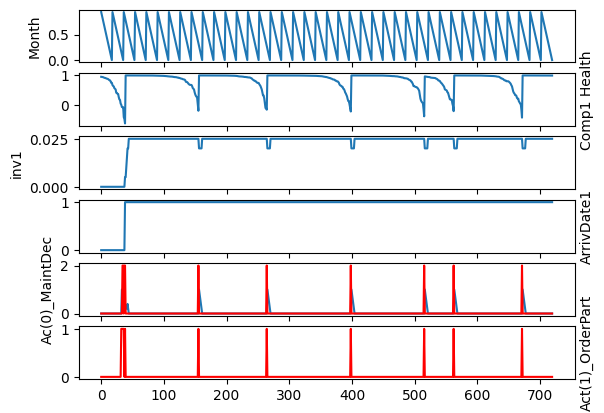

In [374]:
plt.figure()
axs = plt.subplots(sharex=True, sharey=False)

plt.subplot(611), plt.plot(state_log[:,0,0]), plt.ylabel('Month')

plt.subplot(612), plt.plot(state_log[:,0,1]), plt.ylabel('Comp1 Health')
plt.subplot(612).yaxis.set_label_position('right')

plt.subplot(613), plt.plot(state_log[:,0,2]), plt.ylabel('inv1')

plt.subplot(614), plt.plot(state_log[:,0,3]), plt.ylabel('ArrivDate1')
plt.subplot(614).yaxis.set_label_position('right')

plt.subplot(615), plt.plot(state_log[:,0,4]), plt.ylabel('fPartReplaced1')
# plt.subplot(615), plt.plot(actionss, 'r'), plt.ylabel('Ac(0)_MaintDec')
plt.subplot(615), plt.plot(action_log[:,0], 'r'), plt.ylabel('Ac(0)_MaintDec')


plt.subplot(616), plt.plot(action_log[:,1], 'r'), plt.ylabel('Act(1)_OrderPart')
plt.subplot(616).yaxis.set_label_position('right')



Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


(<Axes: ylabel='Observations'>,
 Text(0, 0.5, 'Observations'))

<Figure size 640x480 with 0 Axes>

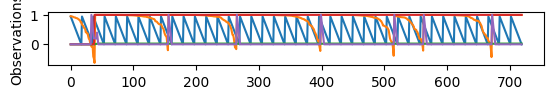

In [380]:
plt.figure()
axs = plt.subplots(sharex=True, sharey=False)

plt.subplot(611), plt.plot(state_log[:,0]), plt.ylabel('Observations')

In [366]:
env = Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A()

observation = env.reset()

observation = tf.ragged.constant(observation)
observation = tf.reshape(observation, (1, -1))

input_data = tf.cast(observation, dtype=tf.float32)
# Create input tensor
input_data = tf.constant(input_data, dtype=tf.float32) 


# Get action probabilities from actor network
action_logits = actorNet_onnx_model.run(input_data)
# action_logits = model_actorNet(observation)
actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])

action_log_prob = tf.argmax(action_logits, axis=-1)
action_index = action_log_prob.numpy().item()

action = actionelements[action_index]
action



array([0, 0])

In [214]:
import tensorflow as tf
import numpy as np

# Load the ONNX model
actorNet_onnx_model = onnx.load("actorNet.onnx")

# Prepare the ONNX model for TensorFlow
tf_rep = prepare(actorNet_onnx_model)

# Create input tensor
input_data = tf.cast(state_tensor_, dtype=tf.float32)

input_data = tf.constant(input_data, dtype=tf.float32)

# Run the model
output_data = tf_rep.run(input_data)

# Print the output
print(output_data)


Outputs(output=array([[0.19127221, 0.15448894, 0.15525818, 0.18365932, 0.15468319,
        0.16063815]], dtype=float32))


In [94]:
# 'Component1', 'Inv1', 'ArrivalDate1', 'fPartReplaced1'

In [ ]:
action_log

In [ ]:
state_log[:,0,0]

In [26]:
len(action_log[:,1])

600

In [27]:
# Define the names of the states
feature_names=['Month', 'Component1', 'Inv1', 'ArrivalDate1', 'fPartReplaced1']

In [30]:
c=action_log[:,1]
norm

In [48]:
(len(action_log))
action_log[:,1].shape

(600,)

In [49]:
cmap='coolwarm'
norm = plt.Normalize(vmin=0, vmax=2) # define color scala between -1 and +1 (like the agents action space)  

fig = plt.figure(figsize=(15,12))
# axs[0].scatter(600, action_log[:,1], c=action_log[:,1] , cmap=cmap, norm=norm)
axs[0].scatter(range(len(action_log)), action_log[:,0], c=action_log[:,0] , cmap = cmap, norm=norm)
axs[0].set_ylabel('action')

Text(0, 0.5, 'action')

<Figure size 1500x1200 with 0 Axes>

In [376]:
def explain(actor = model_actorNet, critic = model_criticNet, state_log_=state_log_, feature_names=feature_names, action_log_=action_log_, cmap='coolwarm', save_fig=False):

    # Build explainer
    # model = ([observation], action) # define inputs and outputs of actor
    
    explainer = shap.KernelExplainer(model_actorNet, state_log_)
    shap_values = explainer.shap_values(state_log_) # Calculate shap values
       
    state_log_re = state_log_ # rescale state log 
    
    norm = plt.Normalize(vmin=0, vmax=2) # define color scala between -1 and +1 (like the agents action space)  
        
    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(6, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(len(action_log)), action_log[:,0], c=action_log[:,0] - explainer.expected_value[0], cmap=cmap, norm=norm)
    axs[0].scatter(range(len(action_log)), action_log[:,1], c=action_log[:,1] - explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action')
    axs[1].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[1].set_ylabel(feature_names[4])   
    axs[1].yaxis.set_label_position('right')
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[3].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[4].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[5].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])   
    axs[5].yaxis.set_label_position('right')   


    
    if save_fig:
        fig.savefig("Shap_RL_Example.pdf", bbox_inches='tight')

    

In [35]:
action_log[:,1].shape

(600,)

  0%|          | 0/720 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


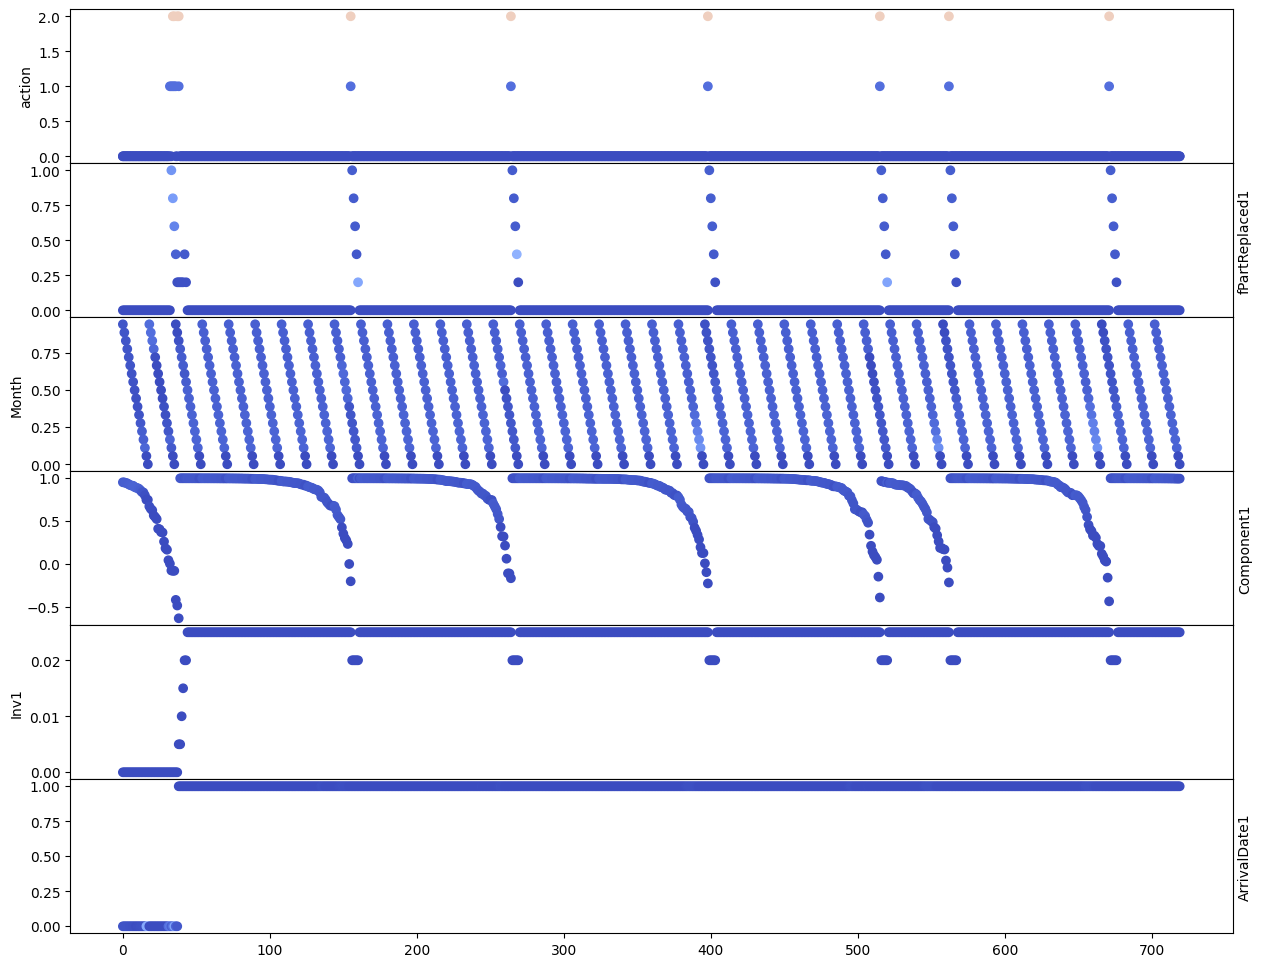

In [377]:
import matplotlib.pyplot as plt

# output with shap values
explain(model_actorNet, model_criticNet, state_log_, feature_names, action_log_)

In [379]:
explainer = shap.KernelExplainer(model_actorNet, state_log_)
shap_values = explainer.shap_values(state_log_) # Calculate shap values

  0%|          | 0/720 [00:00<?, ?it/s]

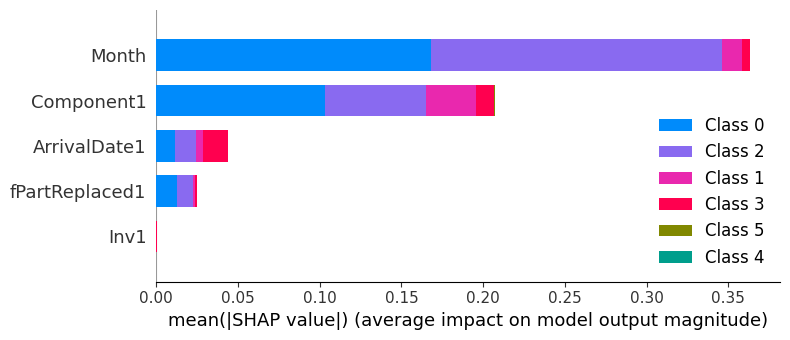

In [381]:
shap.summary_plot(shap_values, feature_names=feature_names)

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


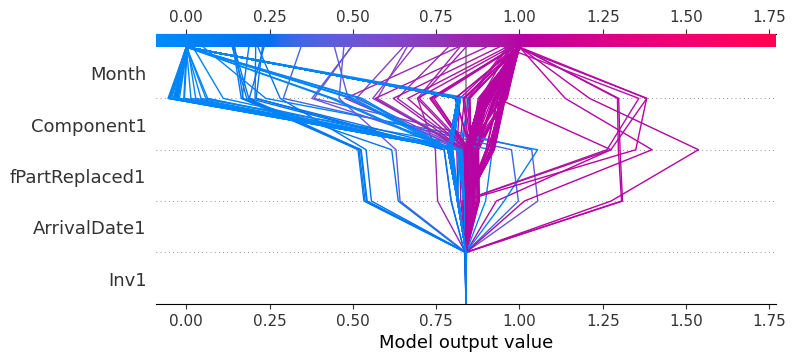

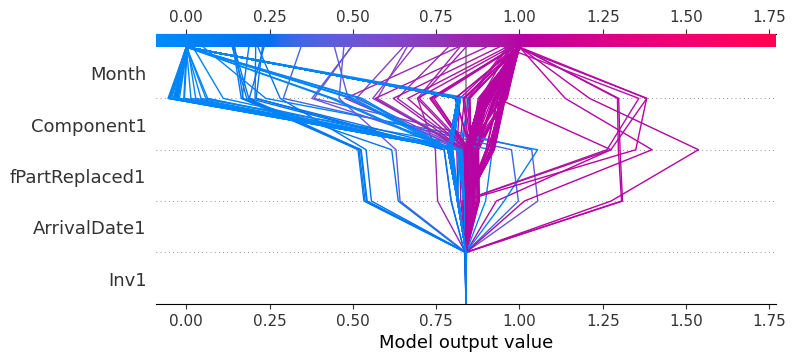

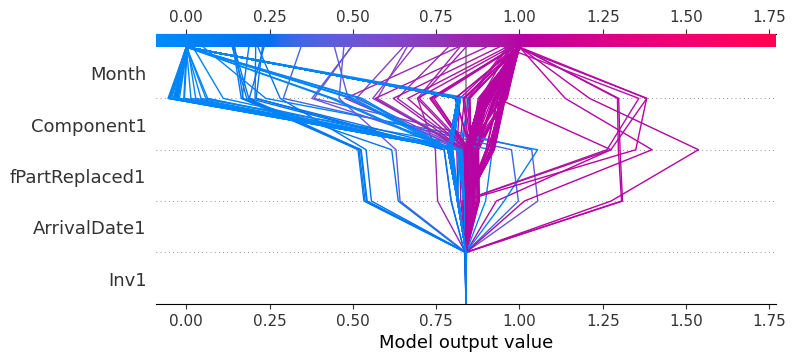

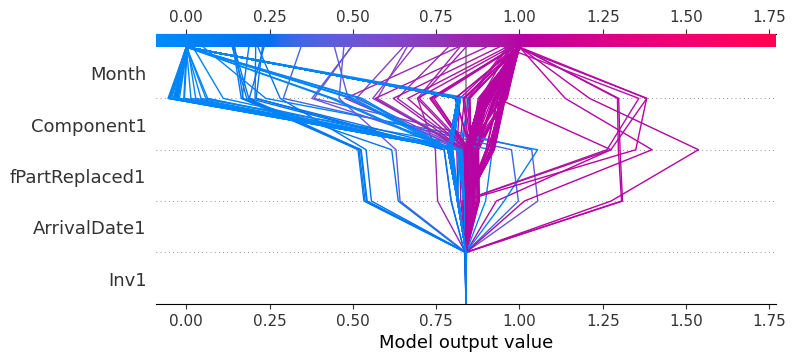

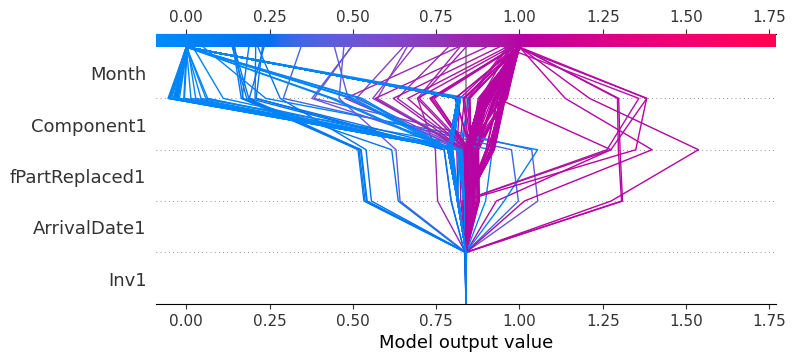

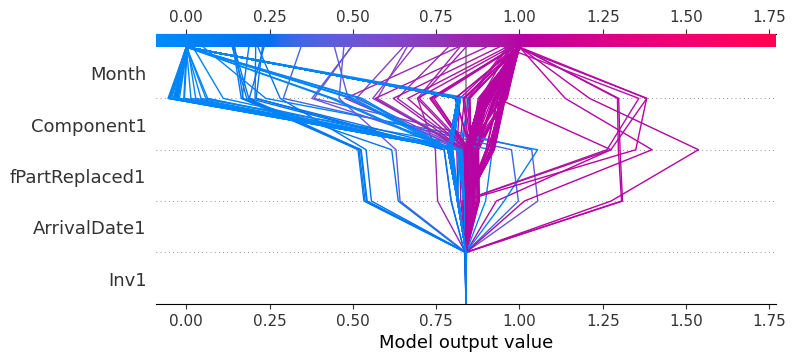

In [382]:
for i in range(len(shap_values)):
  shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names)


In [329]:
explainer = shap.KernelExplainer(model_criticNet, state_log_)
shap_values = explainer.shap_values(state_log_) # Calculate shap values

  0%|          | 0/600 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


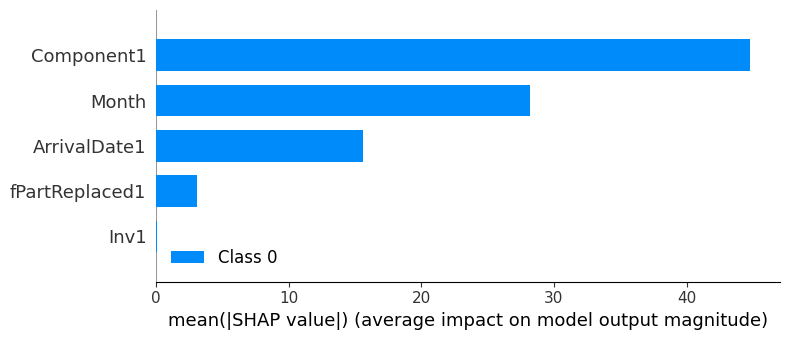

In [330]:
shap.summary_plot(shap_values, feature_names=feature_names)

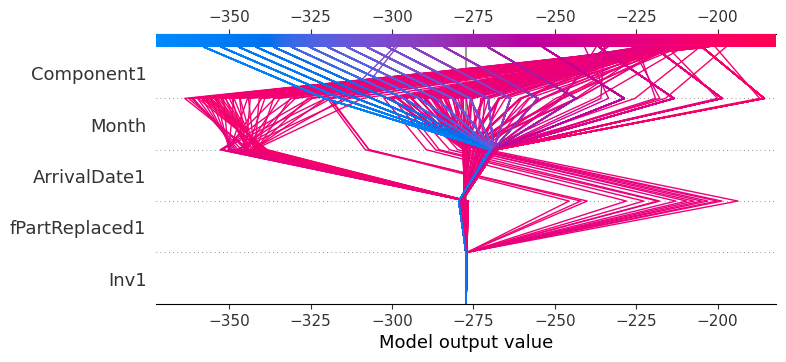

In [331]:
shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names)


